In [2]:
import pandas as pd
import urllib
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from PIL import Image

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Input, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

### Reading data from combined

In [5]:
#reading data
df = pd.read_csv('data/combined.csv')

#dropping not required columns
df.drop(["image_width", "image_height", "image_number"], axis=1, inplace=True)
df.head()

,image_name,top_x,top_y,bottom_x,bottom_y
0,licenced_plates0.jpg,0.722084,0.587983,0.868486,0.688841
1,licenced_plates1.jpg,0.161943,0.850780,0.582996,1.000000
2,licenced_plates2.jpg,0.082000,0.697452,0.230000,0.828025
3,licenced_plates3.jpg,0.434000,0.667377,0.718000,0.765458
4,licenced_plates4.jpg,0.208791,0.390764,0.865135,0.984014


In [6]:
# getting 5 test samples to predict

test_samples = np.random.randint(0, len(df), 5)
reduced_df = df.drop(test_samples, axis=0)

#### Checking images

In [8]:
width = 224
height = 224
channel = 3

def show_img(index):
    image = cv2.imread("data/training_car_images/" + df["image_name"].iloc[index])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, dsize=(width, height))

    tx = int(df["top_x"].iloc[index] * width)
    ty = int(df["top_y"].iloc[index] * height)
    bx = int(df["bottom_x"].iloc[index] * width)
    by = int(df["bottom_y"].iloc[index] * height)

    image = cv2.rectangle(image, (tx, ty), (bx, by), (0, 0, 255), 1)
    plt.imshow(image)
    plt.show()

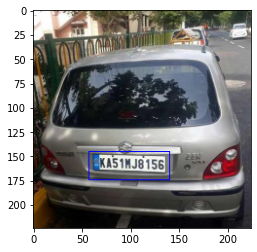

In [9]:
show_img(5)

#### Image data generator

In [10]:
# Image data generator

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.1)

train_generator = datagen.flow_from_dataframe(
    reduced_df,
    directory="data/training_car_images/",
    x_col="image_name",
    y_col=["top_x", "top_y", "bottom_x", "bottom_y"],
    target_size=(width, height),
    batch_size=32, 
    class_mode="other",
    subset="training")

validation_generator = datagen.flow_from_dataframe(
    reduced_df,
    directory="data/training_car_images/",
    x_col="image_name",
    y_col=["top_x", "top_y", "bottom_x", "bottom_y"],
    target_size=(width, height),
    batch_size=32, 
    class_mode="other",
    subset="validation")

Found 599 validated image filenames.
Found 66 validated image filenames.


--- Logging error ---
Traceback (most recent call last):
  File "c:\users\lenovo\appdata\local\programs\python\python38\lib\logging\__init__.py", line 1081, in emit
    msg = self.format(record)
  File "c:\users\lenovo\appdata\local\programs\python\python38\lib\logging\__init__.py", line 925, in format
    return fmt.format(record)
  File "c:\users\lenovo\appdata\local\programs\python\python38\lib\logging\__init__.py", line 664, in format
    record.message = record.getMessage()
  File "c:\users\lenovo\appdata\local\programs\python\python38\lib\logging\__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\users\lenovo\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\lenovo\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "c:\user

#### Model

In [12]:
# model

model = Sequential()
model.add(VGG16(weights="imagenet", include_top=False, input_shape=(height, width, channel)))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="sigmoid"))

model.layers[-6].trainable = False

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               3211392   
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 260       
Total params: 17,938,756
Trainable params: 3,224,068
Non-trainable params: 14,714,688
__________________________________

In [10]:
# step size

step_size_train = int(np.ceil(train_generator.n / train_generator.batch_size))
step_size_val = int(np.ceil(validation_generator.n / validation_generator.batch_size))

print("Train step size:", step_size_train)
print("Validation step size:", step_size_val)

train_generator.reset()
validation_generator.reset()

Train step size: 19
Validation step size: 3


#### Compiling and training model

In [12]:
# Compiling a model

model.compile(optimizer=Adam(lr=0.0005), loss="mse")


# fitting a model

history = model.fit(train_generator,
    steps_per_epoch=step_size_train,
    validation_data=validation_generator,
    validation_steps=step_size_val,
    epochs=30)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
19/19 [==============================] - 77s 4s/step - loss: 0.0294 - val_loss: 0.0183
Epoch 2/30
19/19 [==============================] - 109s 6s/step - loss: 0.0108 - val_loss: 0.0118
Epoch 3/30
19/19 [==============================] - 118s 6s/step - loss: 0.0056 - val_loss: 0.0107
Epoch 4/30
19/19 [==============================] - 120s 6s/step - loss: 0.0034 - val_loss: 0.0098
Epoch 5/30
19/19 [==============================] - 123s 6s/step - loss: 0.0023 - val_loss: 0.0101
Epoch 6/30
19/19 [==============================] - 121s 6s/step - loss: 0.0018 - val_loss: 0.0094
Epoch 7/30
19/19 [==============================] - 124s 7s/step - loss: 0.0016 - val_loss: 0.0090
Epoch 8/30
19/19 [==============================] - 123s 6s/step - loss: 0.0013 - val_loss: 0.0086
Epoch 9/30
19/19 [==============================] - 129s 7s/step - loss: 0.0012 - val_loss: 0.0094
Epoch 10/30
19/19 [===============

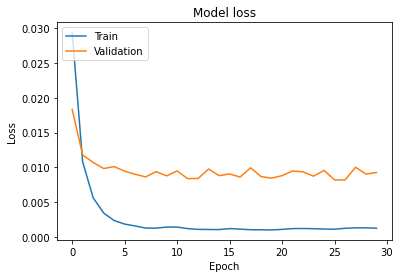

In [29]:
# plotting graph of training

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [15]:
width = WIDTH
height = HEIGHT

### Prediction for test images

<ipython-input-17-4cc82f58f54a>:9: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  image = cv2.rectangle(img, (xt, yt), (xb, yb), (0, 0, 255), 1)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


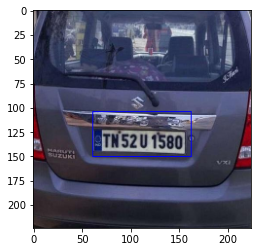

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


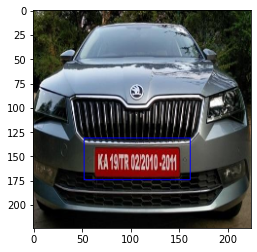

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


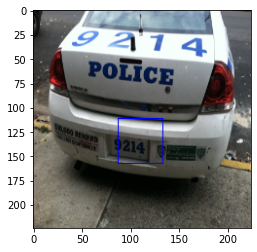

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


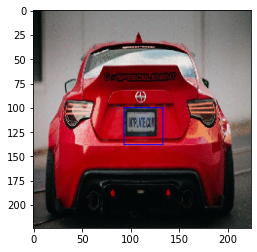

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


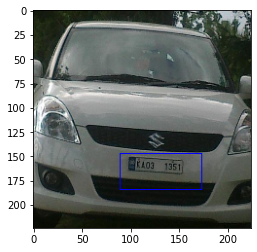

In [17]:
for idx, row in df.iloc[lucky_test_samples].iterrows():    
    img = cv2.resize(cv2.imread("C:/Users/lenovo/Desktop/Python_Prg/Projects/number_plate_recognition/data/training_car_images/" + row[0]) / 255.0, dsize=(WIDTH, HEIGHT))
    y_hat = model.predict(img.reshape(1, WIDTH, HEIGHT, 3)).reshape(-1) * WIDTH
    
    xt, yt = y_hat[0], y_hat[1]
    xb, yb = y_hat[2], y_hat[3]
    
    img = cv2.cvtColor(img.astype(np.float32), cv2.COLOR_BGR2RGB)
    image = cv2.rectangle(img, (xt, yt), (xb, yb), (0, 0, 255), 1)
    plt.imshow(image)
    plt.show()

### Real world testing

#### Function to test model if showing correct plate

In [24]:
def testing_model(image_path,):
    
    width = 224
    height = 224
    
    img = cv2.resize(cv2.imread(image_path) / 255.0, dsize=(width, height))  # need rescaling for predicting
    y_hat = model.predict(img.reshape(1, width, height, 3)).reshape(-1)
    
    # converitng image to array
    img1 = np.array(Image.open(image_path))

    #width & height
    height = img1.shape[0]
    width = img1.shape[1]

    #num plate dimentions
    tx = int(y_hat[0]*width)
    ty = int(y_hat[1]*height)
    bx = int(y_hat[2]*width)
    by = int(y_hat[3]*height)

    # rectangle on image
    img_rct = cv2.rectangle(img=img1, pt1=(bx, ty), pt2=(tx, by), color = (0, 255, 0), thickness=20)

    # plate
    plate = Image.fromarray(img1)
    plate1 = plate.crop(box=(tx,ty,bx,by))

    # plotting
    plt.imshow(img_rct)
    plt.title('Car Image')
    plt.show()

    plt.imshow(plate1)
    plt.title('Plate')
    plt.show()

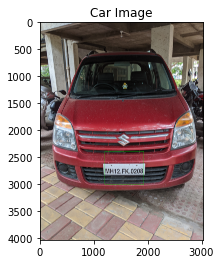

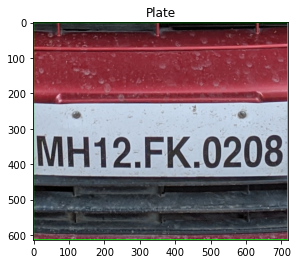

In [19]:
testing_model('data/real_world_testing/IMG_20200828_091557.jpg')

#### Function to crop and plates

In [25]:
def save_plate(image_path, plate_path):
    
    width = 224
    height = 224
    
    img = cv2.resize(cv2.imread(image_path) / 255.0, dsize=(width, height))  # need rescaling for predicting
    y_hat = model.predict(img.reshape(1, width, height, 3)).reshape(-1)
    
    # converitng image to array
    img1 = np.array(Image.open(image_path))

    #width & height
    height = img1.shape[0]
    width = img1.shape[1]

    #num plate dimentions
    tx = int(y_hat[0]*width)
    ty = int(y_hat[1]*height)
    bx = int(y_hat[2]*width)
    by = int(y_hat[3]*height)

    # rectangle on image
    img_rct = cv2.rectangle(img=img1, pt1=(bx, ty), pt2=(tx, by), color = (0, 255, 0), thickness=3)

    # plate
    plate = Image.fromarray(img1)
    plate1 = plate.crop(box=(tx,ty,bx,by))

    # plotting
    plt.imshow(img_rct)
    plt.title('Car Image')
    plt.show()

    plt.imshow(plate1)
    plt.title('Plate')
    plt.show()

    plate1.save(plate_path)
    print('plate image saved at: {}'.format(plate_path))

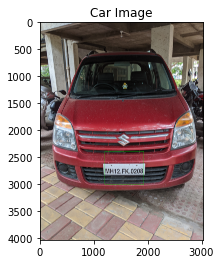

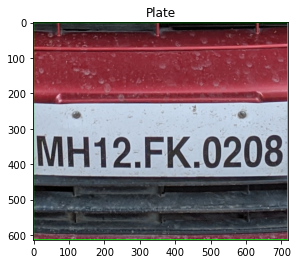

plate image saved at: predicted_plates/plate.jpg


In [26]:
image_path = 'data/real_world_testing/IMG_20200828_091557.jpg' 
plate_path = 'predicted_plates/plate.jpg'   # destination

save_plate(image_path, plate_path)

### Loading and saving model

In [ ]:
# saving model

model.save('model/num_plate_model_1')

In [ ]:
#saving in h5 format

model.save('model/h5_num_plate.h5')

In [ ]:
#loading model

from tensorflow.keras.models import load_model

model = load_model('model/num_plate_model_1')

In [ ]:
# Saving history.history
pd.DataFrame(history.history).to_csv('model/num_plate_model_1.csv')